In [13]:
# pytorch trnasfer learning tutorial 
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from torchvision import datasets, models, transforms
import torchvision
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [4]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2021-10-05 09:50:11--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.230.155.60, 54.230.155.22, 54.230.155.36, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.230.155.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  15.1MB/s    in 3.0s    

2021-10-05 09:50:15 (15.1 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [5]:
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

  inflating: hymenoptera_data/train/bees/2031225713_50ed499635.jpg  
  inflating: hymenoptera_data/train/bees/2037437624_2d7bce461f.jpg  
  inflating: hymenoptera_data/train/bees/2053200300_8911ef438a.jpg  
  inflating: hymenoptera_data/train/bees/205835650_e6f2614bee.jpg  
  inflating: hymenoptera_data/train/bees/208702903_42fb4d9748.jpg  
  inflating: hymenoptera_data/train/bees/21399619_3e61e5bb6f.jpg  
  inflating: hymenoptera_data/train/bees/2227611847_ec72d40403.jpg  
  inflating: hymenoptera_data/train/bees/2321139806_d73d899e66.jpg  
  inflating: hymenoptera_data/train/bees/2330918208_8074770c20.jpg  
  inflating: hymenoptera_data/train/bees/2345177635_caf07159b3.jpg  
  inflating: hymenoptera_data/train/bees/2358061370_9daabbd9ac.jpg  
  inflating: hymenoptera_data/train/bees/2364597044_3c3e3fc391.jpg  
  inflating: hymenoptera_data/train/bees/2384149906_2cd8b0b699.jpg  
  inflating: hymenoptera_data/train/bees/2397446847_04ef3cd3e1.jpg  
  inflating: hymenoptera_data/train/be

  inflating: hymenoptera_data/val/ants/8398478_50ef10c47a.jpg  
  inflating: hymenoptera_data/val/ants/854534770_31f6156383.jpg  
  inflating: hymenoptera_data/val/ants/892676922_4ab37dce07.jpg  
  inflating: hymenoptera_data/val/ants/94999827_36895faade.jpg  
  inflating: hymenoptera_data/val/ants/Ant-1818.jpg  
  inflating: hymenoptera_data/val/ants/ants-devouring-remains-of-large-dead-insect-on-red-tile-in-Stellenbosch-South-Africa-closeup-1-DHD.jpg  
  inflating: hymenoptera_data/val/ants/desert_ant.jpg  
  inflating: hymenoptera_data/val/ants/F.pergan.28(f).jpg  
  inflating: hymenoptera_data/val/ants/Hormiga.jpg  
   creating: hymenoptera_data/val/bees/
  inflating: hymenoptera_data/val/bees/1032546534_06907fe3b3.jpg  
  inflating: hymenoptera_data/val/bees/10870992_eebeeb3a12.jpg  
  inflating: hymenoptera_data/val/bees/1181173278_23c36fac71.jpg  
  inflating: hymenoptera_data/val/bees/1297972485_33266a18d9.jpg  
  inflating: hymenoptera_data/val/bees/1328423762_f7a88a8451.jpg  

In [11]:
data_transforms = {
    'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

data_dir = './hymenoptera_data'
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x])
                 for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

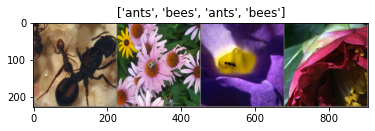

In [15]:
def imshow(inp,title=None):
    '''
    Imshow for Tensor
    '''
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    inp = std*inp+mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out,title=[class_names[x] for x in classes])

In [49]:
def train_model(model,criterion,optimizer,scheduler,num_epochs=25,model_name='no_perturbation_resnet18'):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    
    for epoch in range(num_epochs):
        #print(f'Epoch {epoch+1}/{num_epochs}')
        #print('-'*10)
        
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.
            running_corrects = 0
            
            for inputs,labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            #if epoch % 5 == 0:
            #    print(f'{phase} Loss : {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        #print()
            
    time_elapsed = time.time() - since
    print(f'Model name: {model_name}')
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    print('-'*20)
    print()
    model.load_state_dict(best_model_wts)
    return model

In [50]:
def visualize_model(model,num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs,labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

 --------------------------------------------------------------------------------------
 --------------------------------------------------------------------------------------
 여기가 분수령! 실험설계
 1. SOTA model? - Resnet18, AlexNet, VGG
 2. Simple model?
 3. Perturbation or not?


In [61]:
# SOTA model AlexNet --> finetuning
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25,model_name='no_perturbation_resnet18')

# SOTA model AlexNet + perturbation --> finetuning
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)

for name,parameter in model_ft.named_parameters():
    parameter.data.copy_(parameter+1e-04*torch.randn(parameter.size()).to(parameter.device))

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, model_name='1e-04_perturbation_resnet18')

Model name: no_perturbation_resnet18
Training complete in 1m 3s
Best val Acc: 0.941176
--------------------

Model name: 1e-04_perturbation_resnet18
Training complete in 1m 2s
Best val Acc: 0.947712
--------------------



# ResNet18
#### no - perturbation finetuning model best_accuracy = 94.1176%
#### 1e-04 random perturbation finetuning model best_accuracy = 94.7712%

In [66]:
# SOTA model alexnet --> finetuning
model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features

model_ft.classifier[6] = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25,model_name='no_perturbation_alexnet')

# SOTA model alexnet + perturbation --> finetuning
model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features

model_ft.classifier[6] = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)

for name,parameter in model_ft.named_parameters():
    parameter.data.copy_(parameter+1e-04*torch.randn(parameter.size()).to(parameter.device))

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, model_name='1e-04_perturbation_alexnet')

Model name: no_perturbation_alexnet
Training complete in 0m 44s
Best val Acc: 0.830065
--------------------

Model name: 1e-04_perturbation_alexnet
Training complete in 0m 44s
Best val Acc: 0.882353
--------------------



# AlexNet
#### no - perturbation finetuning model best_accuracy = 83.0065%
#### 1e-04 random perturbation finetuning model best_accuracy = 88.2353%

In [67]:
criterion = nn.CrossEntropyLoss()

# SOTA model vgg16 --> finetuning
model_ft = models.vgg16(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)

optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25,model_name='no_perturbation_vgg16')

# SOTA model vgg16 + perturbation --> finetuning
model_ft = models.vgg16(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)

for name,parameter in model_ft.named_parameters():
    parameter.data.copy_(parameter+1e-04*torch.randn(parameter.size()).to(parameter.device))

optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, model_name='1e-04_perturbation_vgg16')

Model name: no_perturbation_vgg16
Training complete in 1m 34s
Best val Acc: 0.921569
--------------------

Model name: 1e-04_perturbation_vgg16
Training complete in 1m 35s
Best val Acc: 0.947712
--------------------



# VGG16
#### no - perturbation finetuning model best_accuracy = 92.1569%
#### 1e-04 random perturbation finetuning model best_accuracy = 94.7712%

# Random seed 를 고정한다면???

In [83]:
import random
def set_seed(random_seed=101):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False
    np.random.seed(random_seed)
    random.seed(random_seed)

In [84]:
set_seed()
a = torch.randn(5)
print(a)

tensor([-1.3905, -0.8152, -0.3204,  0.7377, -1.7534])


In [90]:
random_seed = 10

In [87]:
# SOTA model AlexNet --> finetuning
set_seed(random_seed)
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25,model_name='no_perturbation_resnet18')

# SOTA model AlexNet + perturbation --> finetuning
set_seed(random_seed)
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)

for name,parameter in model_ft.named_parameters():
    set_seed(random_seed)
    parameter.data.copy_(parameter+1e-04*torch.randn(parameter.size()).to(parameter.device))

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, model_name='1e-04_perturbation_resnet18')

Model name: no_perturbation_resnet18
Training complete in 1m 5s
Best val Acc: 0.954248
--------------------

Model name: 1e-04_perturbation_resnet18
Training complete in 1m 5s
Best val Acc: 0.928105
--------------------



# ResNet18
#### no - perturbation finetuning model best_accuracy = 94.1176%
#### 1e-04 random perturbation finetuning model best_accuracy = 94.7712%

In [88]:
# SOTA model alexnet --> finetuning
set_seed(random_seed)
model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features

model_ft.classifier[6] = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25,model_name='no_perturbation_alexnet')

# SOTA model alexnet + perturbation --> finetuning
set_seed(random_seed)
model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features

model_ft.classifier[6] = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)

for name,parameter in model_ft.named_parameters():
    set_seed(random_seed)
    parameter.data.copy_(parameter+1e-04*torch.randn(parameter.size()).to(parameter.device))

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, model_name='1e-04_perturbation_alexnet')

Model name: no_perturbation_alexnet
Training complete in 0m 46s
Best val Acc: 0.915033
--------------------

Model name: 1e-04_perturbation_alexnet
Training complete in 0m 46s
Best val Acc: 0.875817
--------------------



# AlexNet
#### no - perturbation finetuning model best_accuracy = 83.0065%
#### 1e-04 random perturbation finetuning model best_accuracy = 88.2353%

In [89]:
criterion = nn.CrossEntropyLoss()

# SOTA model vgg16 --> finetuning
set_seed(random_seed)
model_ft = models.vgg16(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)

optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25,model_name='no_perturbation_vgg16')

# SOTA model vgg16 + perturbation --> finetuning
set_seed(random_seed)
model_ft = models.vgg16(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)

for name,parameter in model_ft.named_parameters():
    set_seed(random_seed)
    parameter.data.copy_(parameter+1e-04*torch.randn(parameter.size()).to(parameter.device))

optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, model_name='1e-04_perturbation_vgg16')

Model name: no_perturbation_vgg16
Training complete in 1m 56s
Best val Acc: 0.947712
--------------------

Model name: 1e-04_perturbation_vgg16
Training complete in 1m 57s
Best val Acc: 0.941176
--------------------



# VGG16
#### no - perturbation finetuning model best_accuracy = 92.1569%
#### 1e-04 random perturbation finetuning model best_accuracy = 94.7712%

## random_noise?? --> vector degree??

In [91]:
def torch_cosine_degree(a,b):
    '''
    function for obtaining the degrees between two different vectors
    By using, cosine rule formula
    cos(theta) = dot(a,b)/(abs(a)*abs(b)) --> mid
    theta = np.rad2deg(np.acos(mid))
    '''
    
    mid = torch.dot(a,b)/torch.sqrt(torch.sum(a**2))/torch.sqrt(torch.sum(b**2))
    theta = torch.rad2deg(torch.arccos(mid))
    return theta

In [95]:
criterion = nn.CrossEntropyLoss()

# SOTA model vgg16 --> finetuning
model_ft = models.vgg16(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)

optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25,model_name='no_perturbation_vgg16')

# SOTA model vgg16 + perturbation --> finetuning
model_ft = models.vgg16(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)

max_deg = 0.
for name,parameter in model_ft.named_parameters():
    dummy_vector = parameter +1e-04*torch.randn(parameter.size()).to(parameter.device)
    #parameter.data.copy_(parameter+1e-04*torch.randn(parameter.size()).to(parameter.device))
    parameter.data.copy_(dummy_vector)
    deg = torch_cosine_degree(parameter.view(-1), dummy_vector.view(-1)).detach().cpu().numpy()
    if deg > max_deg:
        max_deg = deg

print('Maximum degree: ',max_deg)
optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, model_name='1e-04_perturbation_vgg16')

Model name: no_perturbation_vgg16
Training complete in 1m 55s
Best val Acc: 0.934641
--------------------

Maximum degree:  tensor(0.0343, device='cuda:0', grad_fn=<Rad2DegBackward>)
Model name: 1e-04_perturbation_vgg16
Training complete in 1m 56s
Best val Acc: 0.941176
--------------------



In [97]:
# SOTA model alexnet --> finetuning
criterion = nn.CrossEntropyLoss()
model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)

optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25,model_name='no_perturbation_alexnet')

# SOTA model alexnet + perturbation --> finetuning
model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)

max_deg = 0.
for name,parameter in model_ft.named_parameters():
    dummy_vector = parameter +1e-04*torch.randn(parameter.size()).to(parameter.device)
    #parameter.data.copy_(parameter+1e-04*torch.randn(parameter.size()).to(parameter.device))
    parameter.data.copy_(dummy_vector)
    deg = torch_cosine_degree(parameter.view(-1), dummy_vector.view(-1)).detach().cpu().numpy()
    if deg > max_deg:
        max_deg = deg

print('Maximum degree: ',max_deg)
optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, model_name='1e-04_perturbation_alexnet')

Model name: no_perturbation_alexnet
Training complete in 0m 46s
Best val Acc: 0.784314
--------------------

Maximum degree:  0.027976455
Model name: 1e-04_perturbation_alexnet
Training complete in 0m 45s
Best val Acc: 0.830065
--------------------



### CIFAR-10 pretrain model --> hymenoptera finetuning